In [ ]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs, build_output
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
from tqdm import tqdm
logger = setup_logger("./external/")

In [ ]:
cfg.merge_from_file("./configs/shufflenetv2_scopehead_object_detection.yml")
# build_output(cfg, "./configs/person.yml")

In [ ]:
cfg.NUM_WORKERS = 1
# cfg.DB.PATH = "/media/allen/mass/DB"
cfg.DB.DATA = "cityperson"
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "scopehead"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = False
cfg.DB.USE_TEST = True
cfg.INPUT.SIZE = (512, 512)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [4]
cfg.DB.TRAIN_TRANSFORM = "RandScale Tensorize"
cfg.DB.TEST_TRANSFORM = "ResizeKeepAspectRatio Tensorize"
cfg.COCO.TARGET = "person"


In [ ]:
loader = LoaderFactory.produce(cfg)
branch = 'val'

In [5]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2
from pycocotools.cocoeval import COCOeval
from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.scopehead_utils import scopehead_det_decode
from tools.oracle_utils import gen_oracle_map
from tools.image import get_affine_transform
from copy import deepcopy
import random

In [ ]:
results = {}
for i, batch in enumerate(loader[branch]):
    batch['bboxes']
    bboxes = np.vstack(batch['bboxes'])
    bboxes[:, [0,2]] *= 128
    bboxes[:, [1,3]] *= 128
    fname = loader[branch].dataset.coco[0].loadImgs(batch['img_id'][0].item())[0]['file_name']
    fname = osp.join(cfg.DB.PATH, "cityperson", "val2017", fname)
    np_img = cv2.imread(fname)
    # np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
    # np_img = cv2.resize(np_img, (512,512))
    
    Image.fromarray(np_img)
    candidates = []
    for b in bboxes:
        x1, y1, x2, y2 = b
        candidates.append([x1, y1, x2, y2, 1.0, 0])
    dets = np.array([candidates])
    dets_out = centernet_det_post_process(
        dets.copy(), 
        batch['c'].cpu().numpy(), 
        batch['s'].cpu().numpy(), 
        batch[(128,128)]['hm'].shape[2], 
        batch[(128,128)]['hm'].shape[3], 
        batch[(128,128)]['hm'].shape[1]
    )[0]
    # for b in dets_out[1]:
    #     x1, y1, x2, y2, score = b
    #     if score > 0.5:
    #         cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
    # if i == 5:
    #     break
    results[batch['img_id'][0]] = dets_out
# Image.fromarray(np_img)

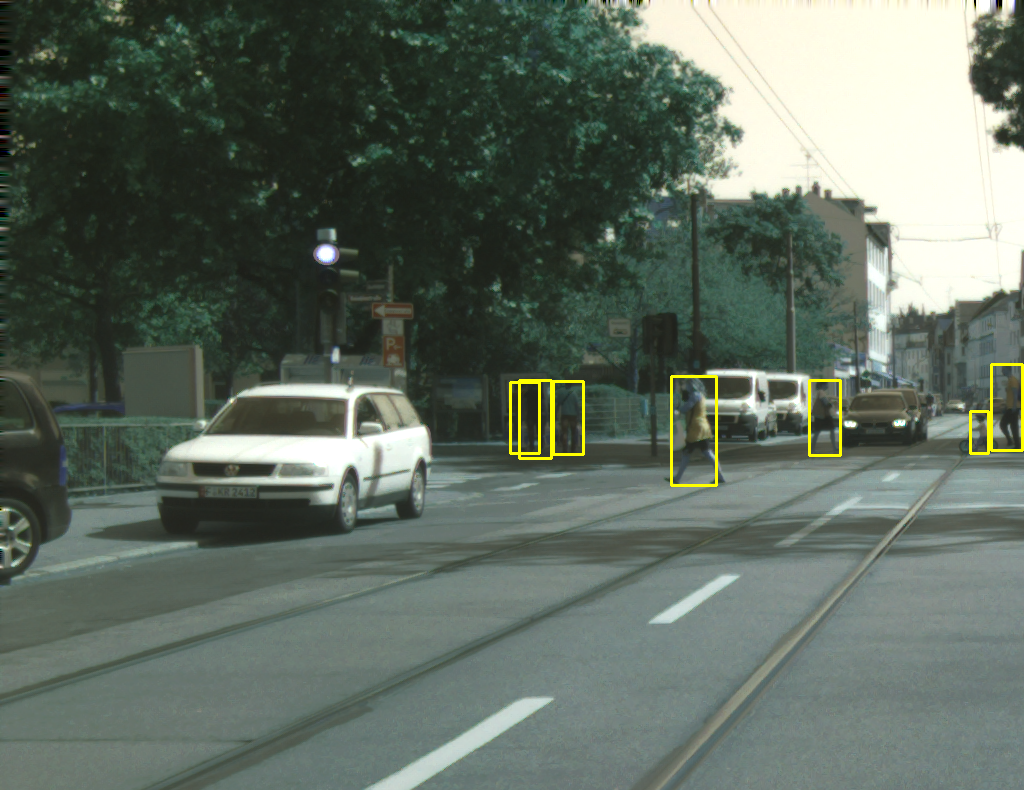

In [6]:
results = {}
for i, batch in enumerate(loader[branch]):
    feat = {}
    out_size = (128,128)
    feat['hm']  = batch[out_size]['hm']
    feat['wh']  = torch.from_numpy(
        gen_oracle_map(
            batch[out_size]['wh'].detach().cpu().numpy(), 
            batch[out_size]['ind'].detach().cpu().numpy(), 
            batch['inp'].shape[3] // cfg.MODEL.STRIDES[0], 
            batch['inp'].shape[2] // cfg.MODEL.STRIDES[0]
        )
    )
    feat['reg'] = torch.from_numpy(
        gen_oracle_map(
            batch[out_size]['reg'].detach().cpu().numpy(), 
            batch[out_size]['ind'].detach().cpu().numpy(), 
            batch['inp'].shape[3] // cfg.MODEL.STRIDES[0], 
            batch['inp'].shape[2] // cfg.MODEL.STRIDES[0]
        )
    )

    dets = scopehead_det_decode(feat['hm'], feat['wh'], reg=feat['reg'], K=100)
    dets = dets.detach().cpu().numpy().reshape(1, 100, -1)
    dets_out = centernet_det_post_process(
        dets.copy(), 
        batch['c'].cpu().numpy(), 
        batch['s'].cpu().numpy(), 
        feat['hm'].shape[2], 
        feat['hm'].shape[3], 
        feat['hm'].shape[1]
    )[0]
    fname = loader[branch].dataset.coco[0].loadImgs(batch['img_id'][0].item())[0]['file_name']
    fname = osp.join(cfg.DB.PATH, "cityperson", "val2017", fname)
    np_img = cv2.imread(fname)
    results[batch['img_id'][0]] = dets_out
#     for b in dets_out[1]:
#         x1, y1, x2, y2, score = b
#         if score > 0.5:
#             cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
#     if i == 5:
#         break
# Image.fromarray(np_img)

In [ ]:
def _to_float(x):
    return float("{:.2f}".format(x))

def convert_eval_format(all_bboxes, valid_ids):
    # import pdb; pdb.set_trace()
    detections = []
    for image_id in tqdm(all_bboxes, desc="COCO EVAL"):
        for cls_ind in all_bboxes[image_id]:
            for bbox in all_bboxes[image_id][cls_ind]:
                bbox[2] -= bbox[0]
                bbox[3] -= bbox[1]
                score = bbox[4]
                bbox_out  = list(map(_to_float, bbox[0:4]))
                category_id = valid_ids[cls_ind - 1]
                detection = {
                    "image_id": int(image_id),
                    "category_id": int(category_id),
                    "bbox": bbox_out,
                    "score": float("{:.2f}".format(score))
                }
                detections.append(detection)
    return detections

def coco_eval(coco, results, save_dir):
    json.dump(convert_eval_format(results, coco.getCatIds()), open('{}/results_gt.json'.format(save_dir), 'w'))
    coco_dets = coco.loadRes('{}/results_gt.json'.format(save_dir))
    coco_eval = COCOeval(coco, coco_dets, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
coco_eval(loader[branch].dataset.coco[0], results, "/home/agent")

In [ ]:
gt_dets = loader[branch].dataset.coco[0].loadRes('/home/agent/results_gt.json')
oracle_dets = loader[branch].dataset.coco[0].loadRes('/home/agent/results_oracle.json')

In [ ]:
gt_anns

In [ ]:
img_ids = gt_dets.getImgIds()
for img_id in img_ids[15:]:
    gt_ann_ids = gt_dets.getAnnIds([img_id])
    gt_anns = gt_dets.loadAnns(gt_ann_ids)
    oracle_ann_ids = oracle_dets.getAnnIds([img_id])
    oracle_anns = oracle_dets.loadAnns(oracle_ann_ids)
    
    fname = loader[branch].dataset.coco[0].loadImgs(img_id)[0]['file_name']
    fname = osp.join(cfg.DB.PATH, "cityperson", "val2017", fname)
    np_img = cv2.imread(fname)
    # np_img2 = np_img.copy()
    for ann in gt_anns:
        x1, y1, w, h = ann['bbox']
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,0), 2)
    for ann in oracle_anns:
        x1, y1, w, h = ann['bbox']
        score = ann['score']
        if score > 0.5:
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,0,255), 2)

    break
Image.fromarray(np_img)

In [ ]:
bboxes = dets_out[1]
# bboxes[:, [0,2]] *= 4
# bboxes[:, [1,3]] *= 4
fname = loader[branch].dataset.coco[0].loadImgs(batch['img_id'][0].item())[0]['file_name']
fname = osp.join(cfg.DB.PATH, "cityperson", "val2017", fname)
np_img = cv2.imread(fname)
# np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
# np_img = cv2.resize(np_img, (512,512))
for b in bboxes:
    x1, y1, x2, y2, score = b
    if score > 0.5:
        print(b)
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [ ]:
dets_out[0].update(d)

In [ ]:
for cls_id in a:
    b[cls_id].extend()

In [ ]:
handle = loader[branch].dataset.coco[0]
# orig_detections = convert_eval_format(results, handle.getCatIds())
# json.dump(orig_detections, open('./external/result.json', 'w'))
coco_dets = handle.loadRes('./external/result.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

In [ ]:
orig_detections[0]

In [ ]:
for orig_b, b in zip(orig_detections, detections):
    diff = np.array(orig_b['bbox']) - np.array(b['bbox'])
    print(diff)
    if diff.sum() > 0:
        print(orig_b)
        print(b)
    

In [ ]:
diff

In [ ]:
img_id = batch['img_id'][0].item()
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "crowdhuman", "val2017", fname)
fname

In [ ]:
# np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.imread(fname)
num = 0
for c in dets_out[0]:
    for b in dets_out[0][c]:
        x1, y1, x2, y2, score = b
        if score > 0.5:
            print(x1, y1, x2, y2)
            num += 1
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
pil_img = Image.fromarray(np_img)
w, h = pil_img.size
# print(num)
pil_img

In [ ]:
def _coco_box_to_bbox(box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]], dtype=np.float32)
    return bbox
ann_ids = handle.getAnnIds(imgIds=[img_id])
anns = handle.loadAnns(ids=ann_ids)
num_objs = len(anns)
src_bboxes = []
for k in range(num_objs):
    ann = anns[k]
    src_bboxes.append(_coco_box_to_bbox(ann['bbox']))

In [ ]:
# np_img = cv2.imread(fname)
for b in src_bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
Image.fromarray(np_img)

In [ ]:
pil_img.size

In [ ]:
src = f"/media/allen/mass/deep-learning-works/evaluation/caltech cityperson cityperson/Hourglass-coco_cityperson_caltech-person-focal_l1-SGDW_cosine_lr_0.01_warmup-scratch/000-2020-04-16_10-03/results.json"
f = open(src, 'r')
results = json.load(f)

In [ ]:
final = []
for result in results:
    if result['score'] > 0.5:
        final.append(result)

In [ ]:
len(result)

In [ ]:
idx = 10
img_id = final[idx]['image_id']
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "cityperson", "val2017", fname)
np_img = cv2.imread(fname)
x1, y1, w, h = final[idx]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,0), 2)
x1, y1, w, h = detections[idx+3]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,255), 2)
Image.fromarray(np_img)

In [ ]:
handle = loader[branch].dataset.coco[0]
image_ids = handle.getImgIds()
detections = []
for img_id in image_ids:
    ann_ids = handle.getAnnIds(imgIds=[img_id])
    anns = handle.loadAnns(ids=ann_ids)
    for ann in anns:
        detection = {
            "image_id": int(img_id),
            "category_id": int(ann['category_id']),
            "bbox": ann['bbox'],
            "score": 1.0,
            'id': int(ann['id'])
        }
        detections.append(detection)
    # breakhandle = loader[branch].dataset.coco[0]
# json.dump(detections, open('./external/results.json', 'w'))
# coco_dets = handle.loadRes('./external/results.json')
# coco_eval = COCOeval(handle, coco_dets, "bbox")
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


In [ ]:
len(orig_detections)

In [ ]:
handle = loader[branch].dataset.coco[0]
json.dump(detections, open('./external/results.json', 'w'))
coco_dets = handle.loadRes('./external/results.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()